# Тема №9. Ускорение.

# Оглавление ноутбука

* <a href="#a1"> Загрузка Mistral-7B-v0.3 </a>
* <a href="#b1"> Outliers в весах LLM </a>
* <a href="#c1"> Квантизация LLM методами GPTQ и bits&bytes </a>
* <a href="#d1"> QLoRA </a>
   * <a href="#d2"> LoRA </a>
   * <a href="#d3"> Инструктивный датасет </a>
   * <a href="#d4"> Создание обучающего датасета </a>
   * <a href="#d5"> Hf Trainer </a>
* <a href="#e1"> Загрузка обученных Low-Rank адаптеров </a>
* <a href="#f1">Выводы и заключение </a>

# <center id="a1"> Загрузка Mistral-7B-v0.3

In [ ]:
!pip install -qqq -U transformers datasets accelerate peft bitsandbytes auto-gptq zstandard jsonlines --progress-bar off

In [1]:
import os
import time
from functools import partial


import torch
import torch.nn as nn
import torch.nn.functional as F

import datasets
from datasets import load_dataset

from pathlib import Path

import transformers
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    LlamaTokenizer,
    LlamaTokenizerFast,
    Trainer,
    DataCollatorForLanguageModeling,
    TrainingArguments
)
from huggingface_hub import snapshot_download

from transformers import GPTQConfig, BitsAndBytesConfig

from peft import (
    prepare_model_for_kbit_training,
    LoraConfig,
    get_peft_model,
    PeftModel,
    TaskType
)

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

# cache директория для хранения файлов, загруженных с hf
# os.environ["HF_HOME"] = "/content/hf_cache"
# os.environ["TRANSFORMERS_CACHE"]= "/content/hf_cache"

os.environ["HF_HOME"] = "/home/hf_cache"
os.environ["TRANSFORMERS_CACHE"]= "/home/hf_cache"

# Константа для маскирования входной последовательности токен
IGNORE_INDEX = -100

def print_memory():
    # Функция измерения затраченной GPU памяти
    device='cuda'
    mem_allocated = torch.cuda.memory_allocated(device=device) / 1024**3
    mem_reserved = torch.cuda.memory_allocated(device=device) / 1024**3
    print(f"allocated: {mem_allocated:,.2f} gb")
    print(f" reserved: {mem_reserved:,.2f} gb")

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Имя модели на hf
model_name = "mistralai/Mistral-7B-v0.3"
# model_name = "NousResearch/Llama-2-7b-hf"
# model_name = "meta-llama/Llama-2-7b-hf"

# mistral_models_path = Path('/content').joinpath('Mistral-7B-v0.3')
model_path = Path('/home').joinpath('model_name')

In [16]:
!rm -r "/content/mistral_model_7B-v0.3"

In [6]:
with open("./hf_token.txt", "r") as f:
    hf_token = f.read()
os.environ["HF_TOKEN"] = hf_token

model_path.mkdir(parents=True, exist_ok=True)
snapshot_download(
    repo_id="mistralai/Mistral-7B-v0.3",
    local_dir=model_path,
    allow_patterns=[
        "params.json",
        "config.json",
        "model.safetensors.index.json",
        "model-00001-of-00003.safetensors",
        "model-00002-of-00003.safetensors",
        "model-00003-of-00003.safetensors",
        "tokenizer.json",
        "tokenizer_config.json",
        "special_tokens_map.json",
        "tokenizer.model"]
)

Fetching 10 files: 100%|██████████| 10/10 [02:17<00:00, 13.76s/it]


'/home/Mistral-7B-v0.3'

In [11]:
# Загрузка предобученной модели
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    trust_remote_code = True,
    device_map = 'cuda:0'
)

Loading checkpoint shards: 100%|██████████| 3/3 [02:24<00:00, 48.08s/it]


In [13]:
print_memory()

allocated: 13.50 gb
 reserved: 13.50 gb


In [14]:
!nvidia-smi

Sun Jul 21 08:03:07 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          Off  | 00000000:CA:00.0 Off |                    0 |
|  0%   41C    P0    86W / 300W |  14792MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
# архитектура модели
model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32768, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRMSNorm(

In [19]:
# Параметры токенайзера
tokenizer_kwargs = {
    "use_fast": True,
    "revision": 'main',
    "trust_remote_code": True,
}

# Загрузка токенайзера
tokenizer = AutoTokenizer.from_pretrained(model_path, **tokenizer_kwargs)

# В Llama подобных моделях отсутствует pad_token
if not tokenizer.pad_token_id:
    tokenizer.pad_token = tokenizer.eos_token

In [20]:
def generate_text(prompt, max_new_tokens=64):
    # Простая функция для генерации текста по входной последовательности токенов

    model_device = model.device
    model_inputs = tokenizer([prompt], return_tensors="pt").to(model_device)
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)
    out = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return out

In [21]:
prompt = "A list of colors: red, blue"
out = generate_text(prompt)
print(out)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A list of colors: red, blue, green, yellow, orange, purple, pink, brown, black, white, gray, silver, gold, tan, beige, peach, cream, tan, ivory, and so on.

A list of colors: red, blue, green, yellow, orange, purple, pink, brown


In [23]:
prompt = "Что такое Сбер?"
tick = time.time()
out = generate_text(prompt)
tock = time.time()
print(out)
print("Time taken: ", tock - tick)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Что такое Сбер?

Сбер — это крупнейший банк России, крупнейший интернет-магазин, крупнейший банковский сервис поставщиков услуг, крупнейший банковский сервис поставщиков у
Time taken:  2.476783275604248


# <center id="b1"> Outliers в весах LLM

Outliers - выбросы в весах (активациях) модели, имеющие очень большое абсолютное значение относительно абсолютного среднего значения остальных весов модели. Появление outliers происходит во время обучения модели. Одной из причин появления outliers [связывают](https://arxiv.org/abs/2306.12929) с недостижимостью функции softmax значения 0.0, что на этапе backward pass приводит к пропуска градиентов, а значит постоянному увеличению некоторых весов.   <br>
<br>
Outliers оказывают очень большое влияние на генеративную эффективность модели, поэтому их искажение может привести к существнной деградации, что мы сейчас и проверим.

In [24]:
@torch.no_grad()
def compute_stats_for_models(model, nlayers = 32):
    """
    Поиск максимального значения среди весов трансформерных блоков декодера
    и расчет среднего значения весов для каждого блока.
    """

    module_name_dict = {name: module for name, module in model.named_modules()}

    decoders_key = 'model.layers.'

    decoders_val = {}
    for i in tqdm(range(nlayers)):
        decoders_val[i] = {}
        decoder_id = decoders_key + str(i)

        decoder = module_name_dict.get(decoder_id)

        nweight = 0
        for name, layer in decoder.named_modules():
            if isinstance(layer, nn.Linear):
                nweight += layer.weight.numel()
                max_current = layer.weight.abs().max()
                if decoders_val[i].get('max_val'):
                    max_current = torch.hstack([decoders_val[i]['max_val'], max_current])
                    decoders_val[i]['max_val'] = torch.max(max_current)
                else:
                    decoders_val[i]['max_val'] = max_current

                sum_val = layer.weight.abs().sum()
                if decoders_val[i].get('mean_val'):
                    decoders_val[i]['mean_val'] += sum_val
                else:
                    decoders_val[i]['mean_val'] = sum_val

        decoders_val[i]['mean_val'] = decoders_val[i]['mean_val'] / nweight

        decoders_val[i]['max_val'] = decoders_val[i]['max_val'].float().cpu().numpy()
        decoders_val[i]['mean_val'] = decoders_val[i]['mean_val'].float().cpu().numpy()

    return decoders_val

In [25]:
decoders_val = compute_stats_for_models(model)
decoders_val = pd.DataFrame.from_dict(decoders_val, orient='index')

100%|██████████| 32/32 [00:00<00:00, 172.37it/s]


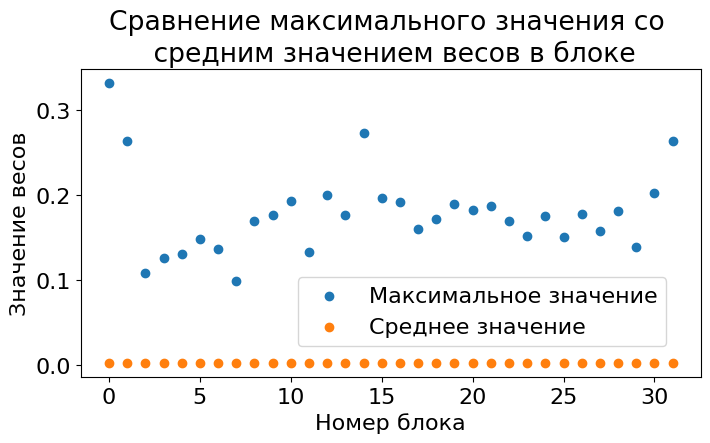

In [26]:
# Отобразим на графике максимальное значение и среднее значение
# весов в блоках трансформера

fig, ax = plt.subplots()
fig.set_size_inches(8, 4)

x_axis = decoders_val.index
y_axis = decoders_val.max_val
ax.scatter(x_axis, y_axis, label=f'Максимальное значение')

x_axis = decoders_val.index
y_axis = decoders_val.mean_val
ax.scatter(x_axis, y_axis, label=f'Среднее значение')

ax.set_title(f'Сравнение максимального значения со \n средним значением весов в блоке')
ax.set_xlabel('Номер блока')
ax.set_ylabel('Значение весов')

ax.legend(loc=(0.35, 0.10))

fig.show()

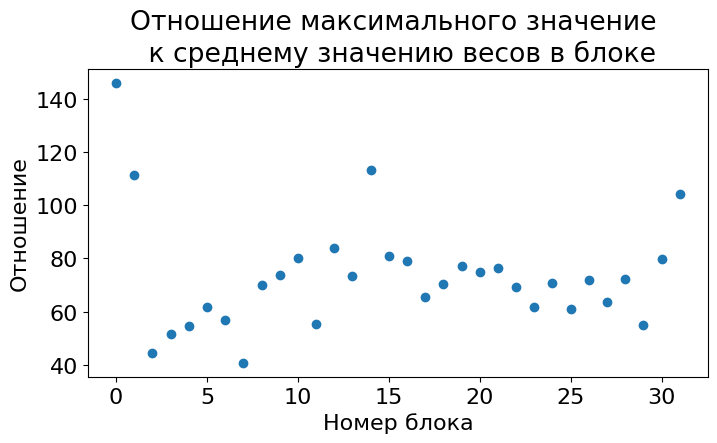

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)

x_axis = decoders_val.index
y_axis = decoders_val.max_val / decoders_val.mean_val
ax.scatter(x_axis, y_axis)

ax.set_title(f'Отношение максимального значение \n к среднему значению весов в блоке')
ax.set_xlabel('Номер блока')
ax.set_ylabel('Отношение')

fig.show()

Видим, что в каждом блоке трансформера присутствуют веса, значение которых на несколько порядков выше среднего значения.

In [28]:
# Набор функций для поиска заданной доли весов с наибольшим абсолютным
# значением в каждом линейном слое модели и их обнуления.

def get_outliers_mask(weight, outlier_fraction):
    """
    Поиск outliers в весах одного слоя
    """

    w = weight
    w_flat = w.view(-1).float()
    lower_threshold, upper_threshold = (
        torch.kthvalue(
            w_flat,
            int(w_flat.numel() * outlier_fraction / 2),
        )[0],
        torch.kthvalue(
            w_flat,
            int(w_flat.numel() * (1 - outlier_fraction / 2)),
        )[0],
    )

    outliers_mask = (w < lower_threshold) | (w > upper_threshold)

    return outliers_mask

def get_names_of_Linear(model):
    """
    Получаем имена всех линейных слоев, входящих в блоки декодера
    """

    names_of_linear_layers = []
    module_name_dict = {name: module for name, module in model.named_modules()}
    for name, module in module_name_dict.items():
        if isinstance(module, nn.Linear) and (name != 'lm_head'):
            names_of_linear_layers.append(name)

    return names_of_linear_layers



@torch.no_grad()
def drop_outliers(model, nlayers=31, outlier_fraction=0.005):
    """
    Обнуление outliers, составляющих `outlier_fraction` долю от всех весов
    каждого слоя декодера.
    """

    module_name_dict = {name: module for name, module in model.named_modules()}

    decoders_key = 'model.layers.'

    decoders_val = {}
    for i in tqdm(range(nlayers)):
        decoders_val[i] = {}
        decoder_id = decoders_key + str(i)

        decoder = module_name_dict.get(decoder_id)

        for name, layer in decoder.named_modules():
            if isinstance(layer, nn.Linear):
                param = layer.weight
                outliers_mask = get_outliers_mask(param, outlier_fraction=outlier_fraction)
                layer.weight.data = (~outliers_mask * param)

In [29]:
# выполнение данной процедуры требует памяти больше, чем предоставляет стандартный Colab
drop_outliers(model)

100%|██████████| 31/31 [00:44<00:00,  1.44s/it]


In [ ]:
# mask = model.model.layers[0].self_attn.q_proj.weight == 0

In [30]:
prompt = "A list of colors: red, blue"
out = generate_text(prompt)
print(out)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A list of colors: red, blue````````````````````````````````````````````````````````````````


In [32]:
prompt = "Что такое Сбер?"
out = generate_text(prompt)
print(out)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Что такое Сбер?````````````````````````````````````````````````````````````````


Мы видим, что после обнуления outliers в весах, количество которых составляет всего 0.5 % от общего количества,
генерирующая способность модели полностью пропала. <br>

Также присутствие outliers в весах существенно усложняет применения линейных методов 
квантизации. <br>
Почему?

# <center id="c1"> Квантизация LLM методами GPTQ, bits&bytes

Один из способов уменьшения памяти, занимаемой моделью в памяти GPU, без существенного падения ее точности заключается в применение методов квантизации. В этом случае значение весов модели конвертируются из fp16/bf16 в форматы данных с меньшим диапазоном (например в int8 / int 4). <br>
<br>

Рассмотрим три метода квантизации широко распространенные на практике: <br>
* **GPTQ** - метод целочисленной симметричной/ассиметричной квантизации, в котором столбцы матрицы каждого слоя квантизуются последовательно слева направо. При этом еще неквантизованные веса обновляются для компенсации ошибки квантизации. Обновление весов происходит в соотвествии с подходом **OBS**, который использует матрицу Гессе $\mathbf{H}$.
* **bits&bytes LLM.int8()** - метод целочисленной симметричной квантизации весов и активаций. Для каждого столбца в матрицах весов и активаций находится своей масштабирующий коэффициент. При этом столбцы в матрицах активаций, содержащие большие значения, могут быть исключены из процедуры квантования для повышения точности.

* **bits&bytes 4nf** - метод вещественнозначной поблочной квантизации, при котором матрицы слоев модели конвертируются в формат nf4 на основе квантильного разбиения их распределения. Размер блоков - 64 элемента. При этом есть возможность дополнительной квантизации параметров масштабирования в формат fp8.  

In [3]:
# model_name = "mistralai/Mistral-7B-v0.3"
# model_name = "NousResearch/Llama-2-7b-hf"
# model_name = "meta-llama/Llama-2-7b-hf"
model_name = "Mistral-7B-v0.3"

mistral_models_path = Path('/content').joinpath('Mistral-7B-v0.3')
model_path = Path('/home').joinpath(model_name)

tokenizer_kwargs = {
    "use_fast": True,
    "revision": 'main',
    "trust_remote_code": True,
}

In [3]:
# Конфиг для квантизации методов GPTQ
quantization_config = GPTQConfig(
    bits=4, #(2, 3, 4, 8)
    dataset=['c4'], #датасет, который будет использоваться для расчета матрицы Гессе H
    damp_percent=0.1, #регуляризующий множитель damp_percent*avg(diagH) для расчета обратной матрицы Гессе H^(-1)
    group_size=128, #количество столбцов в матрице весов W, для которых подбирается параметр квантизации
    sym=True
)

In [4]:
# Единый конфиг, для квантизации LLM.int8() или квантизации nf4/fp4
quantization_config=BitsAndBytesConfig(
    load_in_4bit=True, #квантизация в fp4/nf4
    load_in_8bit=False, #квантизация в int8
    llm_int8_threshold=6.0, #порог для определения outliers в активациях, которые не будут квантоваться
    llm_int8_has_fp16_weight=True, # сохранение весов в fp16
    bnb_4bit_compute_dtype=torch.bfloat16, # тип данных, в которых будут выполняться операции
    bnb_4bit_use_double_quant=False, # нужно ли квантовать параметры квантизации
    bnb_4bit_quant_type='nf4', # fp4 или nf4 тип данных при квантизации в 4бита
)

In [5]:
# Load pretrained model
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    trust_remote_code = True,
    device_map = 'auto',
    quantization_config=quantization_config
)

Loading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_path, **tokenizer_kwargs)

In [7]:
if not tokenizer.pad_token_id:
    tokenizer.pad_token = tokenizer.eos_token

In [8]:
print_memory()

allocated: 4.19 gb
 reserved: 4.19 gb


После квантизации весов объем памяти GPU, занимаемой моделью,  уменьшился с 13gb до 4gb

In [9]:
def generate_text(prompt, max_new_tokens=64):
    model_device = model.device
    model_inputs = tokenizer([prompt], return_tensors="pt").to(model_device)
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)
    out = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return out

In [10]:
prompt = "A list of colors: red, blue"
out = generate_text(prompt)
print(out)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


A list of colors: red, blue, green, yellow, black, white, orange, purple, pink, brown, gray, silver, gold, and rainbow.

A list of colors: red, blue, green, yellow, black, white, orange, purple, pink, brown, gray, silver, gold, and rainbow.


In [11]:
prompt = "Что такое Сбер?"
out = generate_text(prompt)
print(out)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Что такое Сбер?

Сбер — это крупнейший в России банк, он предоставляет широкий спектр финансовых услуг, включая банковские услуги, страхование, инвестиции, кредитные карты,


После квантизации в nf4 ответы модели изменились, но смысл остался прежним

In [16]:
# Архитектура модели после квантизации
# Линейные слои nn.Linear в трансформерных блоках были заменены на квантизованные
# линейные слои Linear4bit.
# Для таких слоев специальным образом программируется forward pass,
# чтобы выполнять деквантизацию во время вычислений. В некоторых случаях также возможно 
# выполнить ускорение расчетов за счет того, что блоки большего размера могут быть 
# загружены в SRAM
model.model

MistralModel(
  (embed_tokens): Embedding(32768, 4096)
  (layers): ModuleList(
    (0-31): 32 x MistralDecoderLayer(
      (self_attn): MistralSdpaAttention(
        (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
        (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
        (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        (rotary_emb): MistralRotaryEmbedding()
      )
      (mlp): MistralMLP(
        (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
        (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
        (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): MistralRMSNorm()
      (post_attention_layernorm): MistralRMSNorm()
    )
  )
  (norm): MistralRMSNorm()
)

In [17]:
#Подготовка квантованной модели к обучению
# 1) веса Embedding Layer, LayerNorm, lm_head конвертируются в fp32
# 2) Отключаем градиент для Embedding Layer, LayerNorm, lm_head
# 3) Подключаем Gradient_Checkpointing

model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)

In [18]:
model.model.embed_tokens.weight

Parameter containing:
tensor([[-2.0336e-36,  3.3208e-37, -1.5517e-35,  ..., -4.9371e-36,
         -7.9934e-36, -5.9480e-36],
        [-4.4250e-03, -2.0981e-05, -5.6458e-03,  ..., -6.5804e-05,
         -1.0300e-03,  8.5354e-05],
        [-1.4572e-03,  8.6975e-04,  1.7357e-04,  ...,  1.0910e-03,
          3.1471e-04,  3.0994e-05],
        ...,
        [ 4.4556e-03, -1.4877e-03,  3.8338e-04,  ..., -5.3942e-06,
          5.5237e-03,  1.2436e-03],
        [-5.3024e-04,  3.3264e-03,  3.2501e-03,  ...,  1.1139e-03,
          1.4572e-03,  9.0408e-04],
        [-3.8147e-03, -6.0654e-04, -5.8594e-03,  ...,  4.2419e-03,
         -4.3106e-04, -2.5024e-03]], device='cuda:0')

In [19]:
model.model.layers[0].post_attention_layernorm.weight

Parameter containing:
tensor([0.4277, 0.4219, 0.4043,  ..., 0.4297, 0.4082, 0.4102], device='cuda:0')

In [20]:
model.model.layers[0].post_attention_layernorm.weight.dtype

torch.float32

In [21]:
model.lm_head.weight

Parameter containing:
tensor([[-0.0028, -0.0003, -0.0024,  ..., -0.0002,  0.0038,  0.0022],
        [-0.0028,  0.0001, -0.0024,  ...,  0.0005,  0.0054,  0.0023],
        [ 0.0035,  0.0046,  0.0027,  ..., -0.0030, -0.0034,  0.0023],
        ...,
        [-0.0033,  0.0014, -0.0056,  ...,  0.0028,  0.0017, -0.0023],
        [-0.0010, -0.0055, -0.0065,  ..., -0.0017,  0.0042,  0.0023],
        [ 0.0042, -0.0047,  0.0037,  ..., -0.0064,  0.0019, -0.0001]],
       device='cuda:0')

# <center id="d1"> QLoRA

## <left id="d2"> LoRA

Попробуем улучшить качество квантованной модели путем применения метода QLoRA.

LoRA адаптер для матрицы весов $\mathbf{W} \in \mathbb{R}^{out \times in}$
$\begin{align}
\mathbf{W} + \dfrac{\alpha}{r}\mathbf{B}\mathbf{A}, \quad r \leq \min \{in, out\}
\end{align}$ <br>
$\mathbf{B} \in \mathbb{R}^{out \times r}$, $\mathbf{A} \in \mathbb{R}^{r \times in}$

Метод дообучения квантованной модели в nf4 с использованием LoRA адапетеров называется QLoRA.

In [22]:
task_type = TaskType.CAUSAL_LM
target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "up_proj", "down_proj", "gate_proj"]
lora_config = LoraConfig(
    task_type=task_type,
    inference_mode=False, #
    r=64,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=target_modules,
    bias="none",
    init_lora_weights=True
)

In [23]:
# Добавляем LoRA адаптеры к квантизованной модели
model = get_peft_model(model, lora_config)

In [24]:
# Архитектура квантизованной модели с LoRA адаптерами
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32768, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): 

При стандартном подходе значения весов адаптеров $A$ инициализируются из стандартного нормального распределения, а значения весов адаптеров $B$ берутся нулевыми.

In [25]:
model.model.model.layers[0].self_attn.q_proj.lora_A['default'].weight

Parameter containing:
tensor([[-0.0132,  0.0152,  0.0072,  ...,  0.0032,  0.0115,  0.0117],
        [ 0.0116,  0.0150,  0.0050,  ...,  0.0074,  0.0156,  0.0070],
        [ 0.0047,  0.0125,  0.0100,  ...,  0.0080,  0.0039,  0.0052],
        ...,
        [-0.0101,  0.0027,  0.0056,  ...,  0.0022,  0.0140,  0.0106],
        [-0.0151, -0.0013, -0.0061,  ..., -0.0095,  0.0079, -0.0067],
        [ 0.0128, -0.0044,  0.0019,  ..., -0.0051, -0.0083,  0.0030]],
       device='cuda:0', requires_grad=True)

In [26]:
model.model.model.layers[0].self_attn.q_proj.lora_B['default'].weight

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)

In [27]:
def print_trainable_parameters(model):
    """
    Количествео обучаемых параметров
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        if param.requires_grad:
            trainable_params += param.numel()

    print(f"trainable params: {trainable_params:,}")

In [28]:
# Количество обучаемых параметрво
print_trainable_parameters(model)

trainable params: 167,772,160


## <left id="d3"> Инструктивный датасет

Инструктивные данные - специально отобранные данные высокого качества, имеющие формат вопрос-ответ. <br> Вопрос пишет пользователь, добавляя при этом дополнительную информацию о рассматриваемом объекте. Развернутый ответ пишется экспертом. В качестве эксперта может быть человек, который является профессионалом в данной области, или более продвинутая и большая языковая модель.

Если сообщения сгенерированны более продвинутой языковой моделью, то к какому классу дообучения можно отнести fine-tuning на инструктивном датасете?

## ru_turbo_saiga
Идёт диалог между пользователем и ИИ ассистентом.
Пользователь и ассистент общаются на тему: {{seed}}
Реплики человека начинаются с [Пользователь], реплики ассистента начинаются с [Ассистент].
Пользователь задаёт вопросы на основе темы и предыдущих сообщений.
Пользователь обрывает беседу, когда у него не остается вопросов.
Ассистент даёт максимально полные, информативные, точные и творческие ответы.
Ассистент старается не задавать вопросов, за исключением уточняющих.
Ассистент может отвечать несколькими абзацами.

[Пользователь] Привет!

[Ассистент] Привет! Чем я могу помочь?


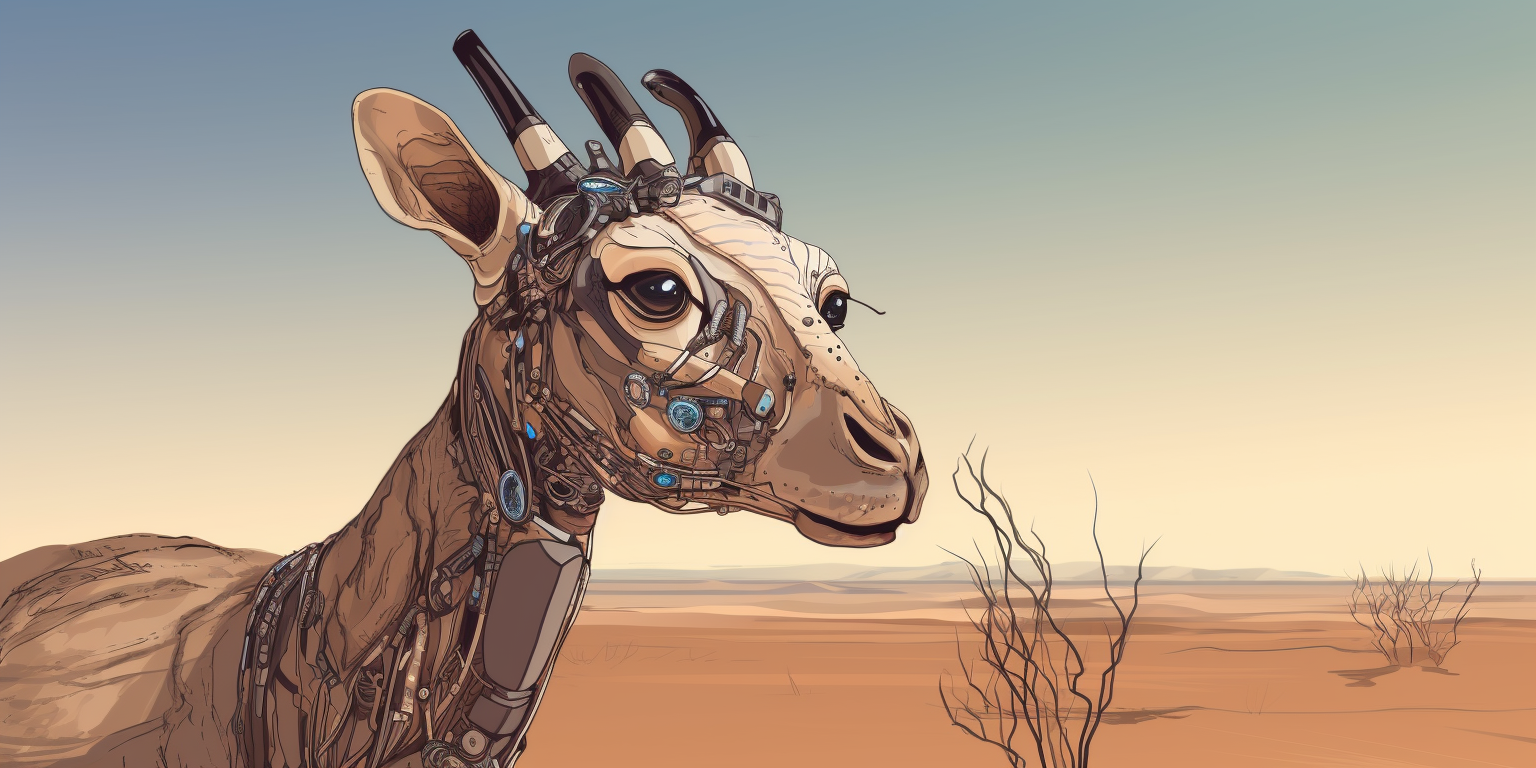

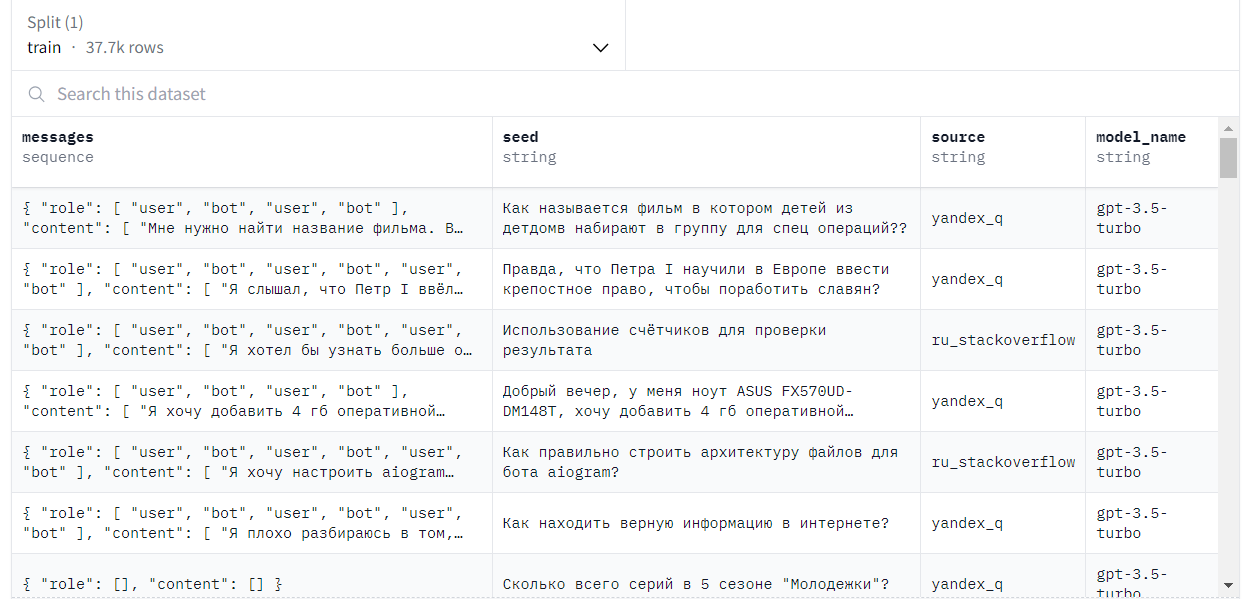

In [29]:
# Загрузка датасета

dataset_name = "IlyaGusev/ru_turbo_saiga"
max_seq_length = 128


raw_datasets = load_dataset(dataset_name, trust_remote_code=True)

#структура датасета
raw_datasets

Generating train split: 100%|██████████| 37731/37731 [00:04<00:00, 7975.66 examples/s]


DatasetDict({
    train: Dataset({
        features: ['messages', 'seed', 'source', 'model_name'],
        num_rows: 37731
    })
})

In [30]:
#пример диалога
example = raw_datasets['train'][0]
example

{'messages': {'role': ['user', 'bot', 'user', 'bot'],
  'content': ['Мне нужно найти название фильма. В нем детей из детдомов набирают в группу для спец операций. Ты можешь мне помочь?',
   'Конечно. Навскидку я могу предложить несколько фильмов. Но, скорее всего, ты ищешь фильм под названием "Сиротский батальон" (англ. "The Little Bastards"). Эту картина, снятая в 2003 году, рассказывает о группе детей совершающих различные военные миссии, посланные на линию фронта.',
   'Да, спасибо. Извини, не было времени на поиск поисковиком. А есть ли другие фильмы на эту тему?',
   'Конечно. Есть еще один фильм, который может заинтересовать тебя. Он называется "Солдаты неудачи" (англ. "Toy Soldiers"). В этом фильме подростки из интернатной школы похищаются террористами, и вынуждены сражаться за свою жизнь. Этот фильм был выпущен в 1991 году.']},
 'seed': 'Как называется фильм в котором детей из детдомв набирают в группу для спец операций??',
 'source': 'yandex_q',
 'model_name': 'gpt-3.5-turbo'}

In [31]:
# исключаем пустые сообщения
raw_datasets['train'] = raw_datasets['train'].filter(lambda example: len(example["messages"]["role"]) > 0)
raw_datasets['train']

Filter:   0%|          | 0/37731 [00:00<?, ? examples/s]

Filter: 100%|██████████| 37731/37731 [00:01<00:00, 30061.07 examples/s]


Dataset({
    features: ['messages', 'seed', 'source', 'model_name'],
    num_rows: 37699
})

### Подготовка диалогов для обучения

In [32]:
# Добавляем в начало каждого сообщения индентификатор, указывающий на источник
# сообщение, т.е. написано ли оно пользователем или сгенерированного ассистентом.

def _add_role(messages):
    for idx in range(len(messages["role"])):
        if messages["role"][idx] == "user":
            messages["content"][idx] = "<|user|>\n" + messages["content"][idx].strip() + "\n"
        elif messages["role"][idx] == "bot":
            messages["content"][idx] = "<|assistant|>\n" + messages["content"][idx].strip() + tokenizer.eos_token + "\n"
        else:
            raise ValueError("Invalid role: {}".format(messages["role"]))

example = raw_datasets['train'][0]
messages = example['messages']
_add_role(messages)
messages

{'role': ['user', 'bot', 'user', 'bot'],
 'content': ['<|user|>\nМне нужно найти название фильма. В нем детей из детдомов набирают в группу для спец операций. Ты можешь мне помочь?\n',
  '<|assistant|>\nКонечно. Навскидку я могу предложить несколько фильмов. Но, скорее всего, ты ищешь фильм под названием "Сиротский батальон" (англ. "The Little Bastards"). Эту картина, снятая в 2003 году, рассказывает о группе детей совершающих различные военные миссии, посланные на линию фронта.</s>\n',
  '<|user|>\nДа, спасибо. Извини, не было времени на поиск поисковиком. А есть ли другие фильмы на эту тему?\n',
  '<|assistant|>\nКонечно. Есть еще один фильм, который может заинтересовать тебя. Он называется "Солдаты неудачи" (англ. "Toy Soldiers"). В этом фильме подростки из интернатной школы похищаются террористами, и вынуждены сражаться за свою жизнь. Этот фильм был выпущен в 1991 году.</s>\n']}

### Токенезация

Сформируем из каждого диалога объект обучающего множества.
Каждый объект этого множества содержит поле 'input_ids', которое соответствует токенизированному сообщению из диалога, и поле 'labels', которое содержит токены, которые будут передаваться в Loss функцию. <br>

Длина последовательности в 'input_ids' и 'labels' совпадает. Однако, в 'labels' часть текста, относящиегося к пользователю, замаскирована. <br>

Если длина сообщения после токенезации превосходит заданный размер, сообщение обрезается.


In [33]:
messages['input_ids'] = []
messages['labels'] = []

message_so_far = 0
for idx, message in enumerate(messages['content']):
    #токенезация входной последовательности
    tokenized_message = tokenizer(message, return_tensors='pt', max_length=max_seq_length, truncation=True)
    messages['input_ids'].append(tokenized_message.input_ids)

    message_so_far += tokenized_message.input_ids.shape[1]

    #токенезация таргета
    if messages["role"][idx] == 'user':
        #текст пользователя маскируется, чтобы не учитывать его в Loss функции
        labels = IGNORE_INDEX * torch.ones_like(tokenized_message.input_ids)

    elif messages["role"][idx] == 'bot':
        labels = tokenized_message.input_ids.clone()

    messages['labels'].append(labels)

    #если длина последвательности превосходит максимальную длину,
    #то прекращаем токенезацию
    if message_so_far >= max_seq_length:
        break

In [34]:
#входная последовательность токенов
messages['input_ids']

[tensor([[    1,  1291, 29534,  2606, 29534, 29535,   781, 29624,  1953, 29473,
           3722, 17056, 16745,  1992, 18138,  3444, 22222,  2298, 29491,  2287,
           3177, 29571,  4465, 23403,  3647,  1710,  3502,  2822, 20032,  1697,
           4556,  1433,  8079,  1417, 18505,  5641,  7054, 16969, 29601, 25657,
          23708, 29491,  3543, 29597, 17671, 29609, 29590,  1899,  1953, 22357,
          29594, 29590, 29572,   781]]),
 tensor([[    1,  1291, 29534,  1257, 11911, 29534, 29535,   781, 29620, 24471,
           8637, 29491,  4528, 29559,  2841, 29567,  2969,  4574,  4793,  6146,
           7746,  1888,  3907,  3057, 25271, 15219, 22222, 20032, 29491, 11826,
          29493, 28767,  1568, 29541, 11548,  1571, 29493,  4033, 29597,  1607,
           4855, 29609, 29590, 22222, 29571,  6776, 18138, 14912,  1113, 29612,
          29540,  1496, 29554,  5472,  8228, 17069,  4231, 29507,  1093, 18826,
          29491,  1113,  1782, 10767, 28009,  2946,  4913,  9179,  3277, 18206,

In [35]:
#токены, которые учится предсказывать модель
messages['labels']

[tensor([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
          -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
          -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
          -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
          -100, -100, -100, -100, -100, -100]]),
 tensor([[    1,  1291, 29534,  1257, 11911, 29534, 29535,   781, 29620, 24471,
           8637, 29491,  4528, 29559,  2841, 29567,  2969,  4574,  4793,  6146,
           7746,  1888,  3907,  3057, 25271, 15219, 22222, 20032, 29491, 11826,
          29493, 28767,  1568, 29541, 11548,  1571, 29493,  4033, 29597,  1607,
           4855, 29609, 29590, 22222, 29571,  6776, 18138, 14912,  1113, 29612,
          29540,  1496, 29554,  5472,  8228, 17069,  4231, 29507,  1093, 18826,
          29491,  1113,  1782, 10767, 28009,  2946,  4913,  9179,  3277, 18206,
           1992,  1380, 29493,  1466,  2739,  1714, 29579,  141

In [35]:
# Все токенезированные сообщение диалога объединяются в один массив входных данных
# Также создается attention_mask
input_ids = torch.hstack(messages['input_ids']).flatten()
labels = torch.hstack(messages['labels']).flatten()

input_ids = input_ids[:max_seq_length]
labels = labels[:max_seq_length]
attention_mask = torch.ones_like(input_ids)

## <left id="d4"> Создание обучающего датасета

Объединим весь рассмотренный код в одну функцию и сформируем
обучающий датасет.

In [36]:
def encode_with_messages_format(example, tokenizer, max_seq_length):
    '''
    Предполагается, что каждый example имеет поле 'messages'.
    Каждое сообщение - словарь, имеющее поля 'role', 'content'.
    Роль, того кто создал сообщение, добавляется в промпт.
    При этом в последовательностях из labels, сообщения от 'user' маскируются.
    На последнем этапе выполняется конкатенация всех сообщений в
    единую последовательность, где роль служит в качестве разделителя.
    '''
    messages = example['messages']
    if len(messages['role']) == 0:
        raise ValueError('messages field is empty.')

    def _add_role(messages):
        for idx in range(len(messages["role"])):
            if messages["role"][idx] == "user":
                messages["content"][idx] = "<|user|>\n" + messages["content"][idx].strip() + "\n"
            elif messages["role"][idx] == "bot":
                messages["content"][idx] = "<|assistant|>\n" + messages["content"][idx].strip() + tokenizer.eos_token + "\n"
            else:
                raise ValueError("Invalid role: {}".format(message["role"]))

    _add_role(messages)

    messages['input_ids'] = []
    messages['labels'] = []
    message_so_far = 0
    for idx, message in enumerate(messages['content']):
        #токенезация входной последовательности
        tokenized_message = tokenizer(message, return_tensors='pt', max_length=max_seq_length, truncation=True)
        messages['input_ids'].append(tokenized_message.input_ids)

        message_so_far += tokenized_message.input_ids.shape[1]

        #токенезация таргета
        if messages["role"][idx] == 'user':
            #текст пользователя маскируется, чтобы не учитывать его в Loss функции
            labels = IGNORE_INDEX * torch.ones_like(tokenized_message.input_ids)

        elif messages["role"][idx] == 'bot':
            labels = tokenized_message.input_ids.clone()

        messages['labels'].append(labels)

        #если длина последовательности превосходит максимальную длину,
        #то прекращаем токенезацию
        if message_so_far >= max_seq_length:
            break

    if len(messages['input_ids']) == 0:
        print(messages)

    input_ids = torch.hstack(messages['input_ids']).flatten()
    labels = torch.hstack(messages['labels']).flatten()

    input_ids = input_ids[:max_seq_length]
    labels = labels[:max_seq_length]
    attention_mask = torch.ones_like(input_ids)

    return {
        'input_ids': input_ids,
        'labels': labels,
        'attention_mask': attention_mask,
    }

In [37]:
dataset_name = "IlyaGusev/ru_turbo_saiga"
max_seq_length = 128


raw_datasets = load_dataset(dataset_name)
raw_datasets['train'] = raw_datasets['train'].filter(lambda example: len(example["messages"]["role"]) > 0)

encode_function = partial(
    encode_with_messages_format,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
)

lm_datasets = raw_datasets.map(
    encode_function,
    batched=False,
    num_proc=8,
    remove_columns=[name for name in raw_datasets["train"].column_names if name not in ["input_ids", "labels", "attention_mask"]],
    desc="Tokenizing and reformatting instruction data",
)

Tokenizing and reformatting instruction data (num_proc=8): 100%|██████████| 37699/37699 [00:05<00:00, 6879.36 examples/s]


In [38]:
train_dataset = lm_datasets['train']

## <left id="d5"> Hf Trainer

Для обучение LoRA адаптеров будем использовать оптимизатор
`paged_adamw_8bit`, который обладает двумя [особенностями](https://huggingface.co/docs/bitsandbytes/main/en/explanations/optimizers):

* **Paged Optimizer** используется для предотвращения переполнения памяти GPU при обучении на длинных входных последовательностях токенов. Если во время обучения объем памяти на GPU превышен, часть данных выгружается в оперативную память. При этом выгрузка данных выполняется в последовательно идущие блоки памяти одинакового размера, что ускоряет передачу данных. <br>
* **Adam_8bit** - реализация mixed precision training. Только параметры оптимизатора сохраняются не в fp16, а квантуются в int8. На этапе расчета градиентов и обновления весов модели параметры оптимизатора деквантуются.

В дополнение к этому используется метод:
**Gradient Clipping** - нормирование градиента, если его норма превосходит заданное предельное значение.

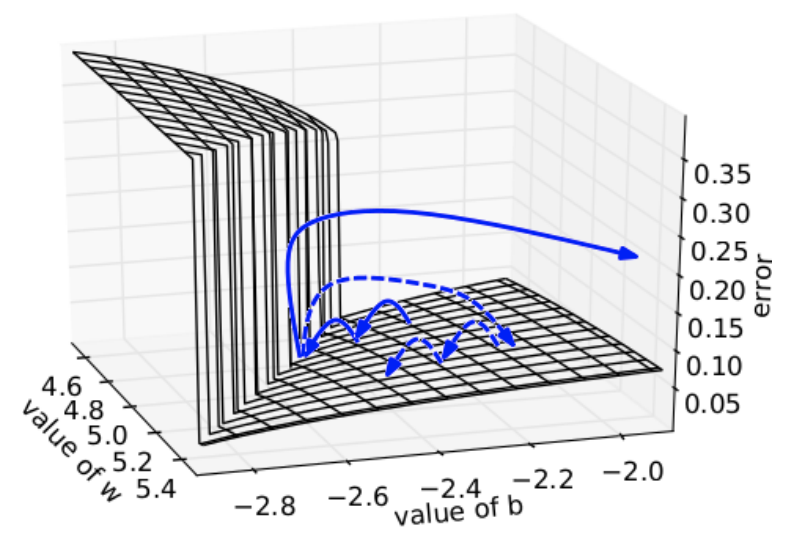

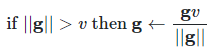

In [39]:
training_args = transformers.TrainingArguments(
    run_name='qlora',
    seed=11,
    per_device_train_batch_size=1, #размер батча на одной GPU
    gradient_accumulation_steps=4, #количество итераций, после которых будет выполнен optimizer.step()
    warmup_ratio=0.03, #доля от общего количества итераций в течение которых будет достигнута максимальная `learning_rate`
    # warmup_steps=2, #количестве итераций, в течение которых будет достигнута максимальная `learning_rate`
    lr_scheduler_type='linear', #cosine, constant - зависимость, по которой уменьшается `learning_rate`
    learning_rate=2e-4,
    max_grad_norm=0.3, # float, default value = 1.0 - gradient clipping by norm
    weight_decay=0.001, # коэффициент для l2 регуляризации
    fp16=True, #mixed precision training
    output_dir="./outputs",
    optim="paged_adamw_8bit", #default = adamw_torch, other adamw_hf, paged_adamw_8bit
    do_train=True,
    save_strategy='steps', #steps, epoch - сохранение checkpoints по итерациям либо по эпохам
    max_steps=10, #максимальное количество итераций
    #num_train_epochs=1, #максимальное количество эпох
    save_steps=2,
    logging_steps=1
)

In [40]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

max_steps is given, it will override any value given in num_train_epochs


In [41]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
1,1.607600
2,1.813500
3,1.326600
4,1.325500
5,1.131700
6,1.009600
7,1.160600
8,1.196000
9,1.021600
10,1.133900


/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /home/Mistral-7B-v0.3 - will assume that the vocabulary was not modified.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /home/Mistral-7B-v0.3 - will assume that the vocabulary was not modified.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_

TrainOutput(global_step=10, training_loss=1.272667944431305, metrics={'train_runtime': 91.1626, 'train_samples_per_second': 0.439, 'train_steps_per_second': 0.11, 'total_flos': 223690075668480.0, 'train_loss': 1.272667944431305, 'epoch': 0.0010610361017533623})

In [42]:
print_memory()

allocated: 5.34 gb
 reserved: 5.34 gb


# <center id="e1"> Загрузка обученных Low-Rank адаптеров

In [2]:
# model_name = "mistralai/Mistral-7B-v0.3"
# model_name = "NousResearch/Llama-2-7b-hf"
# model_name = "meta-llama/Llama-2-7b-hf"
model_name = "Mistral-7B-v0.3"

# mistral_models_path = Path('/content').joinpath('Mistral-7B-v0.3')
model_path = Path('/home').joinpath(model_name)

tokenizer_kwargs = {
    "use_fast": True,
    "revision": 'main',
    "trust_remote_code": True,
}

In [3]:
# Единый конфиг, для квантизации LLM.int8() или квантизации nf4/fp4
quantization_config=BitsAndBytesConfig(
    load_in_4bit=True, #квантизация в fp4/nf4
    load_in_8bit=False, #квантизация в int8
    llm_int8_threshold=6.0, #порог для определения outliers в активациях, которые не будут квантоваться
    llm_int8_has_fp16_weight=True, # сохранение весов в fp16
    bnb_4bit_compute_dtype=torch.bfloat16, # тип данных, в которых будут выполняться операции
    bnb_4bit_use_double_quant=False, # нужно ли квантовать параметры квантизации
    bnb_4bit_quant_type='nf4', # fp4 или nf4 тип данных при квантизации в 4бита
)

In [4]:
# Load pretrained model
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    trust_remote_code = True,
    device_map = 'auto',
    quantization_config=quantization_config
)

Loading checkpoint shards: 100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


In [5]:
# path_to_lora = '/content/outputs/checkpoint-10'
path_to_lora = './outputs/checkpoint-10'
model.load_adapter(path_to_lora)

In [6]:
model.model.layers[0].self_attn.q_proj.lora_B['default'].weight

Parameter containing:
tensor([[-4.6402e-04, -4.2162e-04, -2.4341e-04,  ..., -4.4182e-04,
         -3.9536e-04,  2.3081e-04],
        [ 1.3378e-04,  1.1625e-04,  3.9488e-04,  ...,  2.4310e-04,
          2.3100e-04, -1.9051e-04],
        [-3.3522e-05, -5.4742e-05, -3.0024e-04,  ..., -8.2039e-05,
         -5.0319e-05,  2.4126e-05],
        ...,
        [ 2.5001e-04,  1.4203e-04,  1.7392e-04,  ...,  2.2318e-04,
          1.9182e-04, -2.6907e-05],
        [ 3.5592e-04, -3.5105e-04,  1.7347e-04,  ...,  4.2382e-04,
          3.5536e-04, -4.1438e-04],
        [-2.7524e-04, -6.0928e-05, -1.6787e-04,  ..., -2.4609e-04,
         -2.1430e-04,  1.0089e-04]], device='cuda:0')

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_path, **tokenizer_kwargs)
if not tokenizer.pad_token_id:
    tokenizer.pad_token = tokenizer.eos_token

In [8]:
def generate_text(prompt, max_new_tokens=64):
    model_device = model.device
    model_inputs = tokenizer([prompt], return_tensors="pt").to(model_device)
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)
    out = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return out

In [9]:
prompt = "Что такое Сбер?"
out = generate_text(prompt)
print(out)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Что такое Сбер?
Является ли Сбер банком?
Как работает Сбер?
Как пользоваться Сбер?
Какие услуги предоставляет Сбер?
Как связаться с Сбером?
Как получить поддержку от


In [10]:
prompt = "Ты можешь объяснить, что такое Сбер?"
out = generate_text(prompt)
print(out)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Ты можешь объяснить, что такое Сбер?
Я могу объяснить, что такое Сбер. Сбер - это крупнейший российский банк, который предоставляет широкий спектр финансовых услуг, включая банковские услуги, страхова


После обучение LoRA ответы модели изменились на более специализированные

# <center id="f1"> Выводы и заключение  ✅

<div class="alert alert-success">

В этом уроке мы разобрали:
- outliers в весах модели и их влияние на ее генерацию
- создания конфигов для квантизации моделей методами GPTQ, bits&bytes
- QLoRA для fine-tune квантизованной модели
- создания обучающего датасета на основе корпуса текста с инструкциями